<a href="https://colab.research.google.com/github/Shifath472533/All-Image-captioning-models-and-links-for-data-sets-in-Bangla/blob/master/ResNet_Bangla_(Machine_Translated)_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting up <b>dependencies</b>

In [0]:
!pip install --upgrade pip
!pip install pycocotools
!pip install git+https://github.com/salaniz/pycocoevalcap          #this is for pycocoevalcap library to calulate metrics
!pip install git+https://github.com/Maluuba/nlg-eval.git@master    #this is for nlgeval library to calulate metrics
!nlg-eval --setup

     |████████████████████████████████| 1.4MB 3.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-tt4xvrxt
  Running command git clone -q https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-tt4xvrxt
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.1-py3-none-any.whl size=104310172 sha256=f661b2ba7e259e268728a171ee85bff74003490c9441347a32e1829986755747
  Stored in directory: /tmp/pip-ephem-wheel-cache-rep2fwrq/wheels/df/74/69/758b2491ca93bf681a1509671df34df9cf5ff605edf6e112ed
Successfully built pycocoevalcap
  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-req-build-cppb6zf6
  Running command git clone -q https://github.com/Maluuba/nlg-eval.git /tmp/pip-req-build-cppb6zf6
     |████████████████████████████████| 449 kB 3.3 MB/s 
  Created wheel for nlg-eval: filename=nlg_eval-2.3-py3-none-any.wh

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing to /root/.cache/nlgeval
In case of incomplete downloads, delete the directory and run `nlg-eval --setup /root/.cache/nlgeval' again.
glove2word2vec.py: 100% 1.00/1.00 [00:00<00:00, 350 chunks/s]
dictionary.txt: 550 chunks [00:00, 1.05k chunks/s]
uni_skip.npz: 100% 634/634 [00:23<00:00, 27.3 chunks/s]
uni_skip.npz.pkl: 100% 1.00/1.00 [00:00<00:00, 922 chunks/s]
bi_skip.npz: 100% 276/276 [00:20<00:00, 13.7 chunks/s]
bi_skip.npz.pkl: 100% 1.00/1.00 [00:00<00:00, 1.42k chunks/s]
multi-bleu.perl: 100% 1.00/1.00 [00:00<00:00, 365 chunks/s]
utable.npy: 100% 2.23k/2.23k [01:14<00:00, 30.0 chunks/s]
btable.npy: 100% 2.23k/2.23k [01:17<00:00, 28.8 chunks/s]
glove.6B.zip: 100% 823/823 [06:27<00:00, 2.12 chunks/s]
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for

### Importing the <b>libraries</b>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from numpy import array
import pickle
import numpy as np
import os
import cv2

### Importing Libraries for <b>pycocoevalcap</b>

In [0]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

### Importing Libraries for <b>nlgeval</b>

In [0]:
from __future__ import unicode_literals
import os
import unittest
import nlgeval
from nlgeval import NLGEval
n = NLGEval()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Loading image directory and counting the number of images

In [0]:
cnt = 0
extra = 0
#image directory
img_dir = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flicker8k_Dataset"

for filename in os.listdir(img_dir):
  filename = filename.split(".")[0]
  cnt+=1
    
print("Number of images : " , cnt)
print("Number of captions : " , cnt*5)

Number of images :  9154
Number of captions :  18308


### Defining the directories of token.csv , train , test and validation text files and converting them to **pandas dataframe**

In [0]:
image_tokens=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr8k_bangla.token_main.txt", encoding = "utf-16",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr_8k.trainImages.txt",encoding = "utf-16",names=["img_id"])
test_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr_8k.testImages.txt",encoding = "utf-16",names=["img_id"])
val_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr_8k.devImages.txt",encoding = "utf-16",names=["img_id"])

### Visualizing the <b>image_tokens</b>

In [0]:
image_tokens.head(5)

,img_id,img_caption
0,01.png#0,দুই জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর এক ...
1,01.png#1,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,02.png#0,জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছ...
3,02.png#1,২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চা...
4,03.png#0,অনেক মেয়ে মানুষ বসে আছে।


### Visualizing the <b>train image names</b>

In [0]:
train_image_names.head(5)

,img_id
0,01.png
1,02.png
2,03.png
3,04.png
4,05.png


### Visualising one of the <b>train images</b>

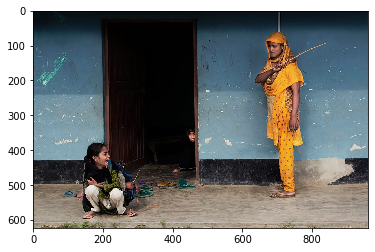

In [0]:
img=cv2.imread(img_dir+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

### removing the #0,#1,#2,#3,#5 from the <b>image ids</b>

In [0]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

### Visualizing the <b>image_tokens</b> again

In [0]:
image_tokens.head(5)

,img_id,img_caption
0,01.png,দুই জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর এক ...
1,01.png,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,02.png,জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছ...
3,02.png,২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চা...
4,03.png,অনেক মেয়ে মানুষ বসে আছে।


### creating train dictionary having *key* as the **image id** and *value* as a list of its **captions**

In [0]:
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 7154/7154 [00:13<00:00, 515.94it/s]


### creating test dictionary having *key* as the **image id** and *value* as a list of its **captions**

In [0]:
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:01<00:00, 519.19it/s]


### creating validation dictionary having *key* as the **image id** and *value* as a list of its **captions**

In [0]:
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:01<00:00, 510.38it/s]


### Importing the **ResNet50** model and printing the **summary**

In [0]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Defining the path to save the **pickle file**

In [0]:
pickle_path = "/content/drive/My /ADriveutomatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/"

### Extracting image encodings(features) from **ResNet50** and forming dict **train_features** and encoding as a <b>pkl</b> file

In [0]:
path=img_dir+"/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

 35%|███▌      | 2527/7154 [13:54<29:37,  2.60it/s]

In [0]:
print("After Extracting Features length of train_features : ")
print(len(train_features))

25


In [0]:
with open( pickle_path+"encoded_train_images_machine_translated.pkl", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [0]:
train_features = {}
pickle_in = open(pickle_path + "encoded_train_images_machine_translated.pkl","rb")
train_features = pickle.load(pickle_in)

In [0]:
print("After Extracting from pkl file length of train_features : ")
print(len(train_features))

25


### Extracting image encodings(features) from **ResNet50** and forming dict <b>test_features</b> and encoding as a <b>pkl</b> file

In [0]:
path=img_dir+"/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

In [0]:
with open( pickle_path+"encoded_test_images_machine_translated.pkl", "wb" ) as pickle_f1:
    pickle.dump(test_features, pickle_f1 )

In [0]:
test_features = {}
pickle_in = open(pickle_path + "encoded_test_images_machine_translated.pkl","rb")
test_features = pickle.load(pickle_in)

### Extracting image encodings(features) from **ResNet50** and forming dict <b>validation_features</b> and encoding as a <b>pkl</b> file

In [0]:
path=img_dir+"/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

In [0]:
with open( pickle_path+"encoded_validation_images_machine_translated.pkl", "wb" ) as pickle_f2:
    pickle.dump(validation_features, pickle_f2 )

In [0]:
validation_features = {}
pickle_in = open(pickle_path + "encoded_validation_images_machine_translated.pkl","rb")
validation_features = pickle.load(pickle_in)

In [0]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

### defining **max_length** and **vocabulary size**

In [0]:
vocab_size=len(unique_words)+1
max_length=40

### forming dictionaries containg mapping of **words to indices** and <b>indices to words</b>

In [0]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### forming dictionary having <b>encoded captions</b>

In [0]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(2):
    print(img_id)
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

In [0]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

In [0]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(2):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

### Importing **Libraries**

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

### Defining <b>Model</b> for generating captions

In [0]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
#lstm_1=LSTM(256)(dropout_2)

#changes done to integrate 1D- Convolutional layer
conv_1D = Conv1D(filters=256, kernel_size=3, activation='relu')(dropout_2)
pool_1 = GlobalMaxPooling1D()(conv_1D)

add_1=add([dense_1,pool_1])
#add_2=add([add_1,pool_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

### Fitting the model with **epoch 1**

In [0]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

### Fitting the model with **epoch 10**

In [0]:
epochs=10
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  print("epoch number : ",i+1)
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

### Defining method for **Greedy Search**

In [0]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

### Defining method for **Beam Search**

In [0]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

### Defining method for calculating scores by **pycocoevalcap**

In [0]:
def calc_scores(ref, hypo):
    print(type(ref))
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [0]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(img_dir+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate_greedy=greedy_search(photo)
  candidate3=beam_search(photo,3)
  candidate5=beam_search(photo,5)
  candidate7=beam_search(photo,7)
  weights = (0.5, 0.5, 0, 0)
# sentence_bleu([reference1, reference2, reference3], hypothesis1, weights)
# , smoothing_function=SmoothingFunction().method1
  score_greedy = sentence_bleu(reference, candidate_greedy, weights)
  score3 = sentence_bleu(reference, candidate3, weights)
  score5 = sentence_bleu(reference, candidate5, weights)
  score7 = sentence_bleu(reference, candidate7, weights)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption for Greedy Search : ")
  print(" ".join(candidate_greedy))
  print("bleu score: ",score_greedy)
  print("Predicted Caption for Beam Search, k=3: ")
  print(" ".join(candidate3))
  print("bleu score: ",score3)
  print("Predicted Caption for Beam Search, k=5: ")
  print(" ".join(candidate5))
  print("bleu score: ",score5)
  print("Predicted Caption for Beam Search, k=7: ")
  print(" ".join(candidate7))
  print("bleu score: ",score7)
  if(i==5):
    break

In [0]:
i=0
tot_score_greedy=0
tot_score3=0
tot_score5=0
tot_score7=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate_greedy=greedy_search(photo)
  candidate3=beam_search(photo,3)
  candidate5=beam_search(photo,5)
  candidate7=beam_search(photo,7)
  score_greedy = sentence_bleu(reference, candidate_greedy,smoothing_function=SmoothingFunction().method1)
  score3 = sentence_bleu(reference, candidate3,smoothing_function=SmoothingFunction().method1)
  score5 = sentence_bleu(reference, candidate5,smoothing_function=SmoothingFunction().method1)
  score7 = sentence_bleu(reference, candidate7,smoothing_function=SmoothingFunction().method1)
  tot_score_greedy+=score_greedy
  tot_score3+=score3
  tot_score5+=score5
  tot_score7+=score7
avg_score_greedy=tot_score_greedy/i
avg_score_k3=tot_score3/i
avg_score_k5=tot_score5/i
avg_score_k7=tot_score7/i
avg_score = (tot_score3+tot_score5+tot_score7+tot_score_greedy)/(i*4)
print()
print("Average Bleu score on Greedy search : ",avg_score_greedy)
print("Average Bleu score on Beam search with k=3 : ",avg_score_k3)
print("Average Bleu score on Beam search with k=5 : ",avg_score_k5)
print("Average Bleu score on Beam search with k=7 : ",avg_score_k7)
print("Average score of all average scores of greedy search and beam search k=3,5,7 is "+str(avg_score))

In [0]:
i=0
for img_id in test_features:
  i+=1
  if(i<5):
    continue
  img=cv2.imread(img_dir+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)

  #generating reference captions  
  ref_caps=[]
  print("Reference Captions: ")
  for cap in reference:
    ref_caps.append(" ".join(cap))

  print(ref_caps)

  candidate_greedy = greedy_search(photo)
  candidate3 = beam_search(photo,3)
  candidate5 = beam_search(photo,5)
  candidate7 = beam_search(photo,7)

  #generating hypothesis captions
  hypo_greedy = " ".join(candidate_greedy)
  hypo_3 = " ".join(candidate3)
  hypo_5 = " ".join(candidate5)
  hypo_7 = " ".join(candidate7)

  print("hypothesis in greedy: ")
  print(hypo_greedy)
  print([hypo_greedy])
  print("hypothesis in beam with k=3")
  print(hypo_3)
  scores_greedy = n.compute_individual_metrics(ref_caps, hypo_greedy)
  scores3 = n.compute_individual_metrics(ref_caps, hypo_3)
  scores5 = n.compute_individual_metrics(ref_caps, hypo_5)
  scores7 = n.compute_individual_metrics(ref_caps, hypo_7)

  print("Results of pycocoevalcap : ")
  ref={}
  hyp={}
  ref[0] = ref_caps
  hyp[0] = [hypo_greedy]
  pycoco_score={}
  pycoco_score = calc_scores(ref,hyp)
  # print(type(calc_scores(ref, hyp)))
  print(pycoco_score)
  for key in pycoco_score:
    print(key," : ",pycoco_score[key])



  print("Referance Captions: ")
  print(ref_caps[0])
  print(ref_caps[1])
  print("Predicted Caption for Greedy Search : ")
  print(hypo_greedy)
  print("Bleu_1 score : ",scores_greedy['Bleu_1'])
  print("Bleu_2 score : ",scores_greedy['Bleu_2'])
  print("Bleu_3 score : ",scores_greedy['Bleu_3'])
  print("Bleu_4 score : ",scores_greedy['Bleu_4'])
  print("METEOR score : ",scores_greedy['METEOR'])
  print("ROUGE_L score : ",scores_greedy['ROUGE_L'])
  print("CIDEr score : ",scores_greedy['CIDEr'])
  print("SkipThoughtCS score : ",scores_greedy['SkipThoughtCS'])
  print("EmbeddingAverageCosineSimilarity score : ",scores_greedy['EmbeddingAverageCosineSimilarity'])
  print("VectorExtremaCosineSimilarity score : ",scores_greedy['VectorExtremaCosineSimilarity'])
  print("GreedyMatchingScore score : ",scores_greedy['GreedyMatchingScore'])
  if(i==5):
    break

In [0]:
scores = {}
final_scores = {}
metrics = ['Bleu_1','Bleu_2','Bleu_3','Bleu_4','METEOR','ROUGE_L','CIDEr','SkipThoughtCS','EmbeddingAverageCosineSimilarity','VectorExtremaCosineSimilarity','GreedyMatchingScore']
search_type = ['greedy','beam_k3','beam_k5','beam_k7']
i=0

for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)

  #generating reference captions  
  ref_caps=[]
  print("Referance Captions: ")
  for cap in reference:
    ref_caps.append(" ".join(cap))


  #generating hypothesis captions
  hypo_greedy = " ".join(candidate_greedy)
  hypo_3 = " ".join(candidate3)
  hypo_5 = " ".join(candidate5)
  hypo_7 = " ".join(candidate7)


  candidate_greedy=greedy_search(photo)
  candidate3=beam_search(photo,3)
  candidate5=beam_search(photo,5)
  candidate7=beam_search(photo,7)
  
  
  
  scores['greedy'] = n.compute_individual_metrics(ref_caps, hypo_greedy)
  scores['beam_k3'] = n.compute_individual_metrics(ref_caps, hypo_3)
  scores['beam_k5'] = n.compute_individual_metrics(ref_caps, hypo_5)
  scores['beam_k7'] = n.compute_individual_metrics(ref_caps, hypo_7)



  

  for s_type in search_type:
    final_scores[s_type] = {}

  for s_type in search_type:
    for metric in metrics:
      final_scores[s_type][metric] = 0.0


  for s_type in search_type:
    for metric in metrics:
      final_scores[s_type][metric] += scores[s_type][metric]
  
if(i==5):
    break


for s_type in search_type:
  print()
  print()
  print(s_type, " : ")
  for metric in metrics:
    print(metric,"  :  ",final_scores[s_type][metric]/i)